# Starting Out: A Binary, Asynchronously Updated Network
What follows is an illustration of the simplest type of hopfield network: one that uses binary valued neurons that update asynchronously using a threshold-based update rule. Demonstrating that this network behaves as expected is a simple sanity check and a stepping stone towards developing more complicated networks.

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Define two 25 dimensional patterns for testing (the letters 'N' and 'Z' in this case)
N = np.array([[1,-1,-1,-1,1], 
              [1,1,-1,-1,1],  
              [1,-1,1,-1,1],  
              [1,-1,-1,1,1],
              [1,-1,-1,-1,1]], dtype=np.float)

Z = np.array([[1,1,1,1,1], 
              [-1,-1,-1,1,-1],  
              [-1,-1,1,-1,-1],  
              [-1,1,-1,-1,-1],
              [1,1,1,1,1]], dtype=np.float)

# Some function definitions
def threshold(inp):
    """Threshold between 1 and -1 at inp equal to 0"""
    return 1 if inp >= 0 else -1

def train(patterns):
    """Build a weight matrix that generates an attractor for each pattern in a list"""
    weights = np.zeros((25,25))
    for p in patterns:
        weights += np.outer(p,p)
    weights[np.diag_indices(25)] = 0
    return weights / float(len(patterns))
    
def update(W, pattern):
    """Asynchronously update each neuron in a network once"""
    pattern = pattern.flatten()
    # Loop through the neurons, updating one by one.
    for n in range(len(pattern)):
        inp = np.dot(W[n,:], pattern)
        pattern[n] = threshold(inp) 
    return pattern

def energy(W, pattern):
    """Get the energy of the current network state"""
    pattern = pattern.flatten()
    return -1*np.dot(pattern.T, np.dot(W,pattern))

To test out the network, we can define some noisy versions of the patterns described above, and then repeatedly update the network to see if it is able to correctly a match a noisy pattern to its clean counterpart. Note that the update rule for the network has the property of monotonically decreasing the value of the energy function (try printing the energy value after each neuron update to check this). 

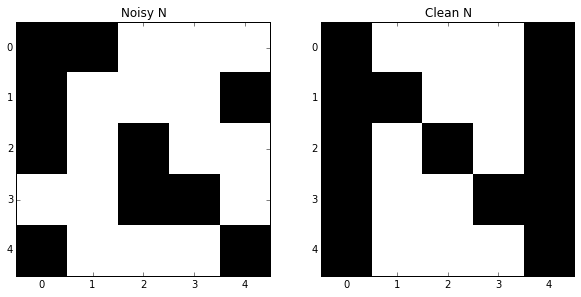

Energy before:  -36.0
Energy after:  -312.0



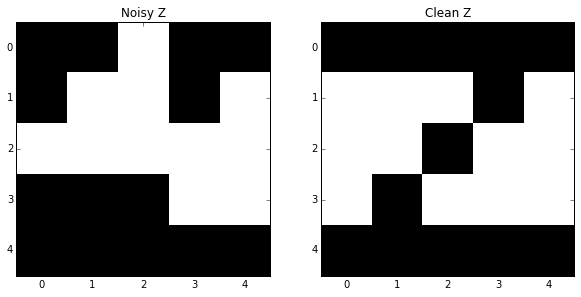

Energy before:  -100.0
Energy after:  -312.0


In [2]:
N_noise = np.array([[1,1,-1,-1,-1], 
                    [1,-1,-1,-1,1],  
                    [1,-1,1,-1,-1],  
                    [-1,-1,1,1,-1],
                    [1,-1,-1,-1,1]], dtype=np.float)

Z_noise = np.array([[1,1,-1,1,1], 
                    [1,-1,-1,1,-1],  
                    [-1,-1,-1,-1,-1],  
                    [1,1,1,-1,-1],
                    [1,1,1,1,1]], dtype=np.float)

weights = train([N, Z])


N_result = update(weights, N_noise)
Z_result = update(weights, Z_noise)

# Plot the results of the network settling.
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(N_noise.reshape((5,5)), cmap=cm.Greys, interpolation='nearest')
plt.title('Noisy N')
plt.subplot(2,2,2)
plt.title('Clean N')
plt.imshow(N_result.reshape((5,5)), cmap=cm.Greys, interpolation='nearest')
plt.show()

print 'Energy before: ', energy(weights, N_noise)
print 'Energy after: ', energy(weights, N_result)
print ''

plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.imshow(Z_noise.reshape((5,5)), cmap=cm.Greys, interpolation='nearest')
plt.title('Noisy Z')
plt.subplot(2,2,2)
plt.title('Clean Z')
plt.imshow(Z_result.reshape((5,5)), cmap=cm.Greys, interpolation='nearest')
plt.show()

print 'Energy before: ', energy(weights, Z_noise)
print 'Energy after: ', energy(weights, Z_result)

# A Binary Network Updated in Continuous Time (Non-Asynchronously)
With some minor adjustments, we can run the network in continuous time with each neuron possessing a continuous activation function. The trick is to use a scaled hyperbolic tangent function as the non-linearity instead of a simple binary threshold, and to update all neurons simultaneously by a small amount. We just need to change the update function to implement this new kind of Hopfield network.

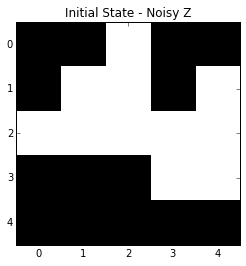

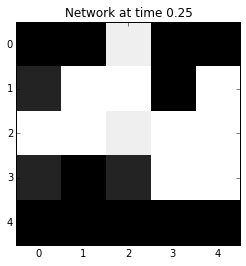

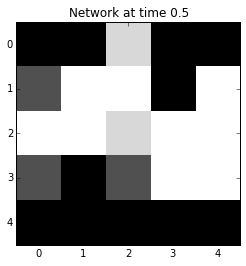

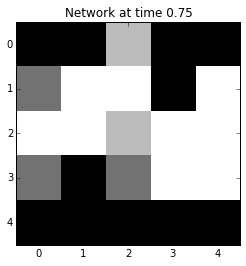

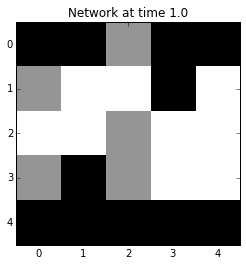

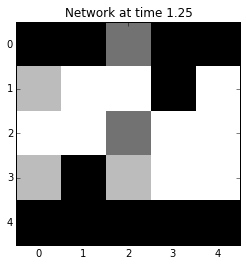

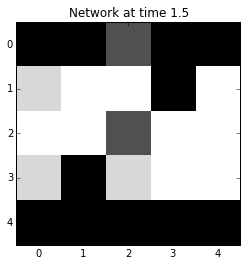

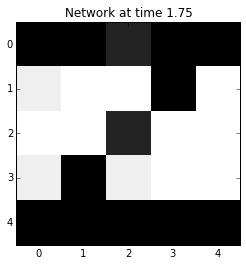

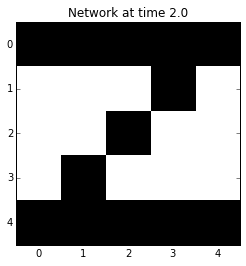

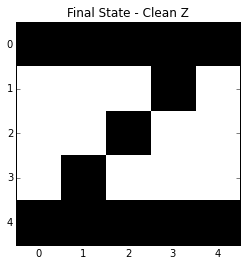

In [3]:
dt = 0.25 # Discretization of continuous time to implement continuous updating.
alpha = 10 # Constant used to scale tanh non-linearity. 

def update(W, pattern, time=2):
    """Simultaneously update all neurons at each time step"""
    for _ in xrange(int(time/dt)):        
        pattern = pattern.flatten()
        pattern += dt * np.tanh(alpha*np.dot(W,pattern))
        pattern = np.clip(pattern, a_min=-1, a_max=1)
        display(pattern, 'Network at time '+str((_ * dt)+dt))
    return pattern

def display(pattern, text):
    """Plot a pattern encoded by a network"""
    plt.imshow(pattern.reshape((5,5)), cmap=cm.Greys, interpolation='nearest')
    plt.title(text)
    plt.show()

display(Z_noise, 'Initial State - Noisy Z')
pattern = update(weights, Z_noise, time=2)
display(pattern, 'Final State - Clean Z')

To give a quick summary and provide some discussion, the binary, asynchronous version of the network generates energy extrema (i.e. maxima and minima) in the corners of an n-dimensional hypercube (where n in this case is 25). So, as the network is updated, it seeks out a state that is the 'best' corner of this hypercube given the constraints encoded in the network's weight matrix and its starting state. 

When we switch to a continuous version of the network, the extrema of the network's energy function are again located at the corners of the n-dimensional hypercube, but they are sought out in a continuous fashion. The discrete network, in contrast, simply jumps from corner to corner on the hypercube until a local minimum of the energy function is obtained.

It is worth exploring whether a continuous version of the network can be used to generate energy minima that are *not* located at the corners of an n-dimensional hypercube. This will be important for implementing hopfield networks that produce attractor states that correspond to holographic reduced representations. To implement real valued minima, we first modify the update and energy function definitions in accordance with Hopfield (1984).

# A Two-Neuron Network with Real-Valued Stable Points
As a starting sanity check, we can replicate a simple two-neuron flip-flop circuit from Hopfield (1984). The update rule and energy function are redefined here to incorporate a differential equation that describes the rate of change
of the input to a given neuron with respect to time. Via the chain rule, this rate is converted into a rate of change for the activation of a given neuron with respect to time. The energy function is modified to reflect this change to the upate rule such that energy still monotonically decreases over time. 

The key parameter of this two-neuron network is alpha, which regulates the steepness of the non-linearity applied to each neuron. As alpha increases, the network functions identically to its discrete counterpart (the non-linearity asymptotically approaches a step function).  As alpha decreases, the stable points of the network can be drawn back from the corners of the n-dimensional hypercube, but a certain point they collapse towards a single stable point centered at the origin of the vector space. The plots below illustrate how stable points can be generated for real-valued vectors, but only in limited sense: they are "drawn in" from the corners of the hypercube, and eventually collapse into a single attractor. See Hopfield 1984 for discussion. 

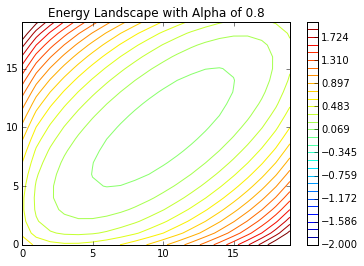

START:  [-0.8  0.1]
END:  [-0.04125883 -0.04125883]


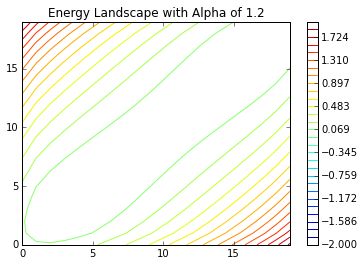

START:  [-0.8  0.1]
END:  [-0.63692584 -0.63692581]


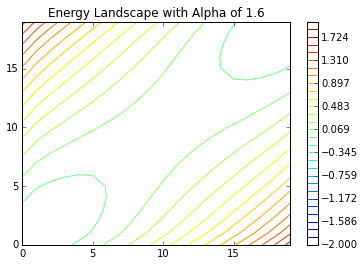

START:  [-0.8  0.1]
END:  [-0.8904721  -0.89047209]


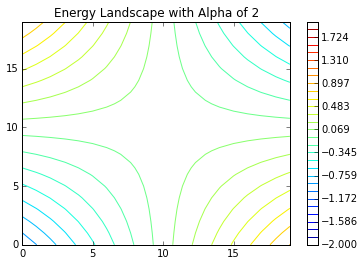

START:  [-0.8  0.1]
END:  [-0.95750402 -0.95750402]


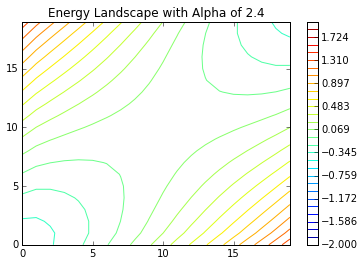

START:  [-0.8  0.1]
END:  [-0.98223458 -0.98223458]


In [4]:
import itertools
from scipy import integrate

dt = 0.01
tau = 1 # Standard parameters unknown - seems to tradeoff against alpha.
alpha = 1.4
weights = np.array([[0,1],[1,0]]) # These weights determine which corners of the hypercube correspond to stable points.

# Updated and new function definitions.
def integral(activation, dx=0.0001):
    """Compute the integral of arctanh from 0 to x=activation"""
    return integrate.quad(np.arctanh, 0.0, activation)

def update(W, pattern, time=1):
    """Simultaneously update all neurons at each time step using Hopfield's differential equations"""
    for _ in xrange(int(time/dt)):        
        pattern = pattern.flatten()
        inp = np.arctanh(pattern) / alpha
        dx = (-(inp / tau) + np.dot(W, pattern)) * dt
        da = np.tanh(inp + dx) - np.tanh(inp)
        pattern += da
        pattern = np.clip(pattern, a_min=-0.999, a_max=0.999)
    return pattern

def energy(W, pattern):
    """Get the energy of the current network state"""
    core = -0.5*np.dot(pattern.T, np.dot(W,pattern))
    unit = ((1/tau)/alpha) * sum([integral(activation)[0] for activation in pattern])
    return core + unit

def plot_energy_contour(W):
    """Plot a contour map of the energy function for a simple two-neuron network"""
    vals = np.zeros((20,20))
    x = np.arange(-1, 1, 0.1)
    grid = np.array(list(itertools.product(x, x))).reshape(20,20,2)
    for i,j in enumerate(grid):
        for k, l in enumerate(j):
            vals[i,k] = energy(W, l)
    plt.figure()
    landscape = plt.contour(vals, levels=np.linspace(-2,2,30))
    plt.colorbar(landscape)
    plt.title('Energy Landscape with Alpha of '+str(alpha))
    plt.show()

        
start_state = np.array([-0.8, 0.1])

# Compare the energy landscape across a range of parameter values.    
alphas = [0.8, 1.2, 1.6, 2, 2.4]
for a in alphas:
    alpha = a
    plot_energy_contour(weights)
    print 'START: ', start_state
    print 'END: ', update(weights, start_state, time=10)

These plots illustrate how increasing alpha shifts the energy landscape from a regime in which a single attractor is located at the origin to a regime in which two attractors are located in the top-left and bottom-right regions of the state-space. Eventually, these attractors are pushed to the corners of the state-space, making the stable points of the network again be equivalent to the corners of a 2D box (or hypercube, more generally). Notice the change in the resting state under different values of alpha using a constant starting state. 

Next, to see if it is possible to control where these stable points are located, we can try adjusting the bias or background input provided to each neuron. This results in simple changes to the update rule and energy function as follows:

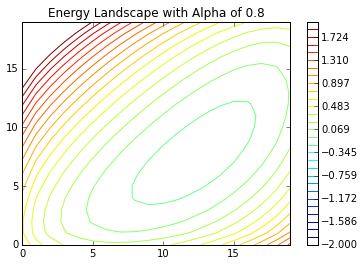

START:  [-0.8  0.1]
END:  [-0.26551433  0.21789651]


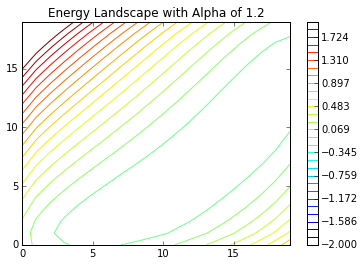

START:  [-0.8  0.1]
END:  [-0.69299034 -0.16559263]


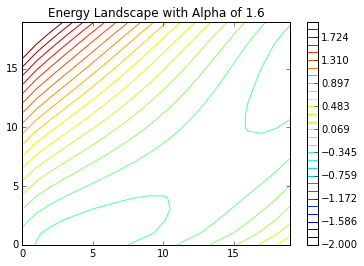

START:  [-0.8  0.1]
END:  [-0.94241128 -0.55197855]


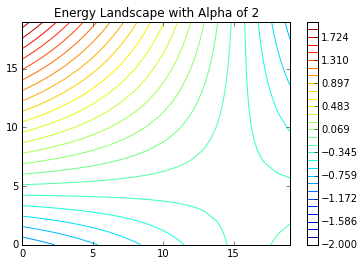

START:  [-0.8  0.1]
END:  [-0.98670893 -0.70198873]


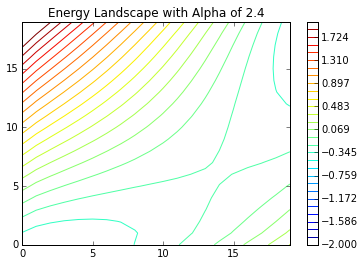

START:  [-0.8  0.1]
END:  [-0.99678464 -0.78989196]


In [5]:
bias = np.array([-0.55,0.55])
tau = 1

def update(W, pattern, time=1):
    """Simultaneously update all neurons at each time step using Hopfield's differential equations"""
    for _ in xrange(int(time/dt)):        
        pattern = pattern.flatten()
        inp = np.arctanh(pattern) / alpha
        dx = (-(inp / tau) + np.dot(W,pattern) + bias) * dt
        da = np.tanh(inp + dx) - np.tanh(inp)
        pattern += da
        pattern = np.clip(pattern, a_min=-0.999, a_max=0.999)
    return pattern

def energy(W, pattern):
    """Get the energy of the current network state"""
    core = -0.5*np.dot(pattern.T, np.dot(W,pattern))
    unit = ((1/tau)/alpha) * sum([integral(activation)[0] for activation in pattern])
    base = -1*sum(np.multiply(pattern, bias))
    return core + unit + base

start_state = np.array([-0.8, 0.1])

# Compare the energy landscape across a range of parameter values.    
alphas = [0.8, 1.2, 1.6, 2, 2.4]
for a in alphas:
    alpha = a
    plot_energy_contour(weights)
    print 'START: ', start_state
    print 'END: ', update(weights, start_state, time=10)

These observations indicate that adjusting the bias can allow for some control over whether the stable points are real or binary valued vectors. However, it is not clear that a stable point can be generated for any vector whatsoever - further analysis is required on this issue. It is also unclear whether stable points can be generated for HRR vectors, which are typically located on the unit hypersphere. The next section investigates this issue. 

# Using a Hopfield Network with HRRs as Stable Points
What follows is a simple test of whether or not a continuous hopfield network can be used to generate attractors in a high-dimensional state space that correspond to holographic reduced representations.

In [6]:
import nengo
from nengo.dists import SubvectorLength

D = 128

# New function definitions for dealing with HRRs
def disturb(v, std=0.001):
    """Add mean-zero gaussian noise to a vector"""
    return v + np.random.normal(loc=0, scale=std, size=len(v)) 

def norm_of_vector(v):
    """Return the length of a vector"""
    return np.linalg.norm(v)

def normalize(v):
    """Normalize a vector"""
    return v / norm_of_vector(v)

def clip(v):
    """Clip a vector to fit in state space of the hopfield network"""
    return np.clip(v, a_min=-0.999, a_max=0.999)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


Next, we initialize the HRRs, weights, and bias:

In [7]:
# Set the scaling factor on the vectors and make a random bias vector.
scale = SubvectorLength(D).invcdf(np.asarray(0.99))
bias = clip(normalize(np.random.randn(D))/scale)

# Generate 3 random HRRs to use as desired stable points.
patterns = ['P1','P2','P3']
patterns = {p: clip(normalize(np.random.randn(D))/scale) for p in patterns}

# Build a weight matrix from the pattern HRRs
weights = np.zeros((D,D))
for p in patterns:
    weights += np.outer(patterns[p], patterns[p])

# Matrix for computing the similarity of a given state to the desired stable points
stack = np.vstack(tuple(patterns.values()))
stack /= np.transpose(np.tile(np.linalg.norm(stack, axis=1), (D, 1)))

Now, it possible to see how well the network is able to translate noisy HRRs into clean versions. We simply choose one of the patterns, randomly distort it by a small amount, and initialize the network in a state corresponding to this distorted pattern. We can then plot the similarity of the network's state to each of the patterns corresponding to a desired stable point. The network's state should gravitate towards the pattern that it is initially closest to. 

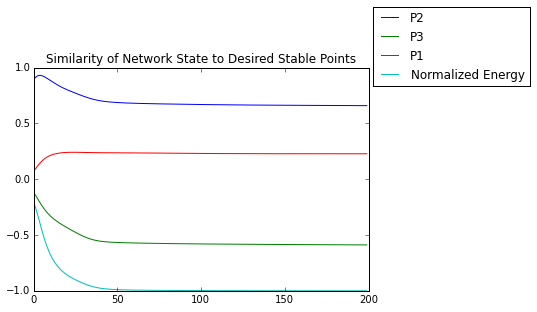

In [8]:
# Disturb one of the patterns randomly to create a starting state for the network.
test_state = clip(disturb(patterns['P2'], std=0.2))

# Parameters
alpha = 1.2
tau = 1
dt = 0.01
T = 2

# Add logging to update procedure.
def update(W, pattern, time=0.5):  
    """Simultaneously update all neurons at each time step using Hopfield's differential equations"""
    sims = np.zeros((len(patterns), time/dt))
    ens = np.zeros(time/dt)
    for _ in xrange(int(time/dt)):        
        pattern = pattern.flatten()
        inp = np.arctanh(pattern) / alpha
        dx = (-(inp / tau) + np.dot(W,pattern) + bias) * dt
        da = np.tanh(inp + dx) - np.tanh(inp)
        pattern += da
        pattern = np.clip(pattern, a_min=-0.999, a_max=0.999)
        sims[:,_] = np.dot(stack, normalize(pattern))
        ens[_] = energy(weights, pattern)
    return sims, ens

sims, ens = update(weights, test_state, time=T)

# Plot the state trajectory of the hopfield network over time.
for i in range(sims.shape[0]):
    plt.plot(range(int(T/dt)), sims[i,:])
plt.plot(range(int(T/dt)), ens/-min(ens))
plt.legend(patterns.keys()+['Normalized Energy'], bbox_to_anchor=(1.5, 1.3))
plt.title('Similarity of Network State to Desired Stable Points')
plt.show()

It is informative to compare the trajectory of the Hopfield network to the trajectory of a linear system with the same weight matrix. We can observe the degree to which the linear system diverges from the behavior of the Hopfield network under different values of alpha. It is clear that the behavior of the linear system diverges quite substantially from that of the hopfield network.

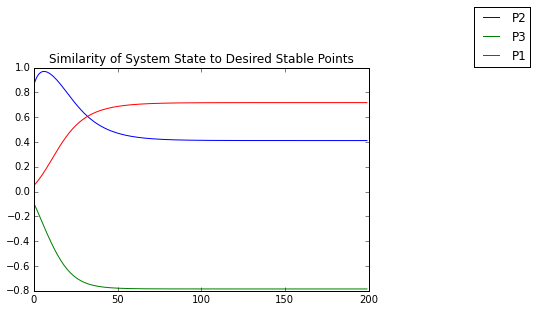

In [9]:
# Perform eigendecomposition on the weight matrix and convert input state into a linear comb. of eigenvectors.
eigvals, eigvecs = np.linalg.eig(weights)
coefficients = np.linalg.solve(eigvecs, test_state)

# Plot the system's trajectory over time by solving the system at each time step.
trange = np.arange(0, T, dt)
sims = np.zeros((len(patterns), T/dt))

for t in trange:
    solution = normalize(np.dot(eigvecs, coefficients * np.exp(eigvals*t))).real
    sims[:,np.where(trange==t)[0][0]] = np.dot(stack, normalize(solution)).real

for i in range(sims.shape[0]):
    plt.plot(range(int(T/dt)), sims[i,:])
plt.legend(patterns.keys(), bbox_to_anchor=(1.5, 1.3))
plt.title('Similarity of System State to Desired Stable Points')
plt.show()


Depending on the starting state of the network (i.e. the random disturbance applied to a chosen pattern), the degree to which network gravitates towards the correct stable point can vary. It is also possible to vary additional parameters such as alpha, tau, or the random bias applied to each neuron. Differences in the random generation of initial pattern vectors also seem to make a difference.

Because this behavior is somewhat less than robust, we next consider a case in which the HRRs have been specially selected to be pointing in the direction of a hypercube corner. 

In [10]:
# Revised Parameters
alpha = 1.5
dt = 0.001
T = 1

# Generate HRRs from a uniform distribution to use as desired stable points.
patterns = ['P1','P2','P3','P4','P5']
patterns = {p: np.random.choice(np.array([0.5,-0.5]), D) for p in patterns}
bias = np.random.choice(np.array([-0.25,0.25]), D)

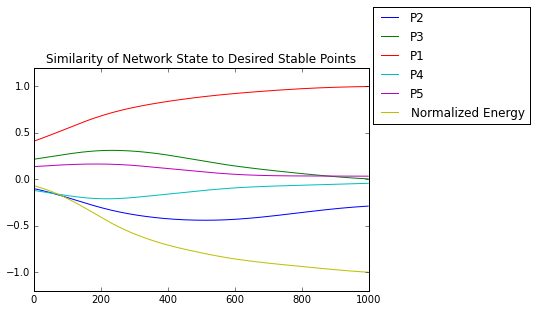

In [11]:
# Build a weight matrix from the pattern HRRs
weights = np.zeros((D,D))
for p in patterns:
    weights += np.outer(patterns[p], patterns[p])
weights /= len(patterns)

# Matrix for computing the similarity of a given state to the desired stable points
stack = np.vstack(tuple(patterns.values()))
stack /= np.transpose(np.tile(np.linalg.norm(stack, axis=1), (D, 1)))

test_state = clip(disturb(patterns['P1'], 1) + patterns['P3'] / 2.0)

sims, ens = update(weights, test_state, time=T)
# Plot the state trajectory of the hopfield network over time.
for i in range(sims.shape[0]):
    plt.plot(range(int(T/dt)), sims[i,:])
plt.plot(range(int(T/dt)), ens/-min(ens))
plt.ylim([-1.2,1.2])
plt.legend(patterns.keys()+['Normalized Energy'], bbox_to_anchor=(1.5, 1.3))
plt.title('Similarity of Network State to Desired Stable Points')
plt.show()

These results indicate that the network is effective at transitioning towards to the appropriate stable point given a particular starting point, provided that the stable points are HRRs generated from a mean zero uniform distribution over the (scaled) corners of the hypercube.

This is not a particularly desirable constraint, so we next consider a network architecture that is similar to the hopfield network, but uses of a kind of localist encoding on which each neuron is semantically interpretable.

#Recurrently Connected Associative Memories

With this network architecture, the goal is to avoid placing any restriction on the kinds of vectors that can serve as stable points in the network's state space. 

In [14]:
from scipy.special import logit

T = 1
dt = 0.01
k = 25

# Use sigmoid as non-linearity
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-1.0 * x))

# Clipping for sigmoid non-linearity
def clip(v):
    return np.clip(v, a_min=0.001, a_max=0.999)

# Revised to modify the pattern over a single timestep      
def update(W, pattern):  
    pattern = pattern.flatten()
    inp = (logit(pattern) / alpha) - bias / alpha
    dx = (-(inp / tau) + np.dot(W,pattern)) * dt
    da = k * (sigmoid(inp + dx) - sigmoid(inp))
    pattern += da
    pattern = clip(pattern)
    return pattern

# Use randomly chosen HRRs from unit hypersphere
patterns = ['P1','P2','P3','P4','P5','P6','P6','P8','P9','P10']
patterns = patterns = {p: normalize(np.random.randn(D)) for p in patterns}

# Define factors of weight matrix
weights_in = np.row_stack([v for v in patterns.values()])
weights_out = np.column_stack([v for v in patterns.values()])
weights = np.dot(weights_in, weights_out)
# weights += 0.1*(np.eye(len(patterns))-1) # Add mutual inhibition

# Check which elements of the state vector correspond to which HRR
print patterns.keys()
print np.dot(weights_in, patterns['P1'])

['P2', 'P3', 'P1', 'P6', 'P4', 'P5', 'P8', 'P9', 'P10']
[-0.0083266   0.05262656  1.          0.01240132  0.07077428 -0.0889617
 -0.00431424  0.00261028 -0.13698862]


[ 0.51213498  0.05267743  0.52810873  0.39629485  0.16928844 -0.19330028
  0.18647324  0.42526779 -0.13170376]
[ 0.53030028  0.01128172  0.56981276  0.26171931  0.03532789  0.00097412
  0.04167571  0.32140508  0.00180203]



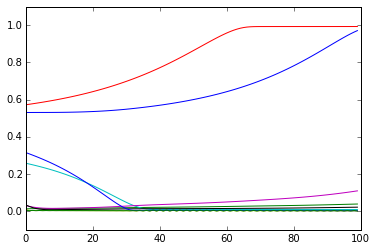

In [24]:
inp = normalize(disturb(np.dot(weights_in, 0.5*patterns['P1']+0.4*patterns['P2']), 0.25))

# Shift the tuning curves
alpha = 10
bias = -5*np.ones(len(patterns))

state = sigmoid(alpha*inp+bias)
state_log = np.zeros((len(patterns), int(T/dt)))
print inp
print state
print ''

# Run the network
for step in xrange(int(T/dt)):  
    state = update(weights, state)
    state_log[:, step] = state
    
#Plot the results
for i in range(state_log.shape[0]):
    plt.plot(range(int(T/dt)), state_log[i,:])
plt.ylim([-0.1,1.1])
plt.show()

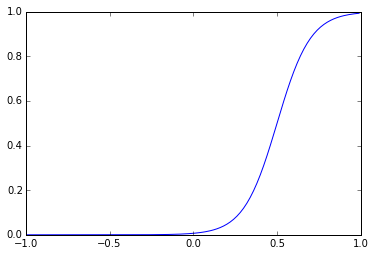

In [25]:
# Plot of the non-linearity being used to threshold. 
alpha = 10
plt.figure()
plt.plot(np.arange(-1,1,0.01), sigmoid(alpha*np.arange(-1,1,0.01)-5))
plt.show()